In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100

import geopandas as gpd

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


from os import listdir
import unicodedata


from paths import *
from scripts.io import read_sheets
from scripts import io


from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

from IPython.display import IFrame


import yaml
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)


# Brasil.IO

In [2]:
from scripts import io

brio, brio_raw = io.load_brasilIO()

print("Br.IO table, Done!")

Br.IO table, Done!


In [3]:
brio

,city_ibge_code,city,confirmed,deaths,date,state
12188,2310506.0,Pedra Branca,1,0,2020-04-12,CE
13245,3200102.0,Afonso Cláudio,1,0,2020-04-13,ES
13246,3200300.0,Alfredo Chaves,1,0,2020-04-13,ES
13248,3200607.0,Aracruz,7,0,2020-04-13,ES
13249,3201001.0,Boa Esperança,1,0,2020-04-13,ES
...,...,...,...,...,...,...
15897,4127957.0,Tupãssi,1,0,2020-04-15,PR
15898,4128104.0,Umuarama,2,0,2020-04-15,PR
15899,4128203.0,União da Vitória,3,0,2020-04-15,PR
15900,4128609.0,Verê,2,0,2020-04-15,PR


## WCota
 - [github](https://github.com/wcota/covid19br)

In [4]:
# #data https://github.com/wcota/covid19br
# dd = io.load_wcota()


## MYTABLE

In [9]:
from scripts.io import read_sheets
from scripts import manipulation

io.update_ms_data()

df = pd.read_csv("../data/ministerio_da_saude/last_data_ms_covid19.csv")

df_states = manipulation.manipule_mytable(df,config['ms_table'])
print("States table, Done!")

States table, Done!


In [10]:
vale = read_sheets('covid19_vale_do_paraiba_e_litoral_norte').replace('',0)
print("Vale table, Done!")

Vale table, Done!


### GRAPHS

[Local - Indicator Model](file:///mnt/0BF8481B1CDBF12D/Jlab/gabinete_sv/covid19/images/storage/br_indicator_model.html)

[Local - Indicator Final](file:///mnt/0BF8481B1CDBF12D/Jlab/gabinete_sv/covid19/images/storage/br_indicator_final.html)

[GS-Indicator_Final](https://storage.googleapis.com/sv-covid19/brasil/br_indicator_final.html)

In [11]:
from scripts import vis_html
vis_html.create_cards(df_states,vale,config['embed_html'])


#     io.to_storage(bucket='sv-covid19',
#               bucket_folder='site/full',
#               file_name=files[model],
#               path_to_file=path+files[model])
    
# print("Embed link uploaded")

Done!
Embed html uploaded!


In [12]:
# IFrame(src=path, width=1500, height=600)

In [19]:
from scripts import io
from scripts import vis_graphs

config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)
themes = yaml.load(open('../themes/custom_colorscales.yaml', 'r'), Loader=yaml.FullLoader)

df_states = df_states.sort_values(by=['date'],ascending=False)


# io.br_cumulative_generate_upload(df_states,config['br_cumulative'],themes)

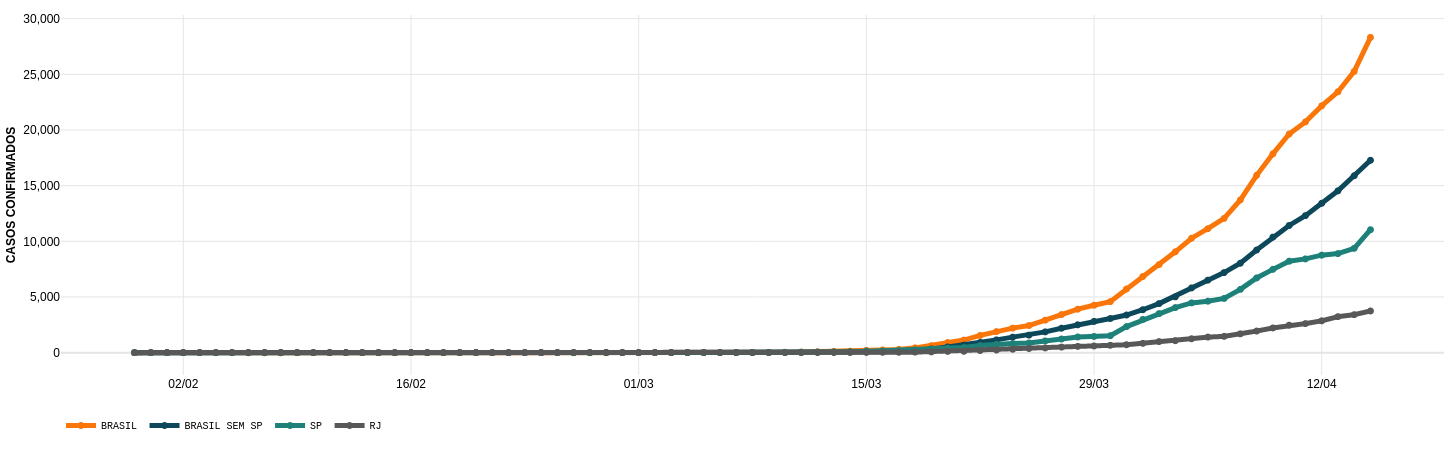

In [20]:
themes = yaml.load(open('../themes/custom_colorscales.yaml', 'r'), Loader=yaml.FullLoader)

var = 'confirmed'
in_cities = ['BRASIL','BRASIL SEM SP','SP', 'RJ']

vis_graphs.brasil_vis(df_states,
                 var,
                 in_cities,
                 today=today,
                 save=False,
                 themes=themes['novo_storage'])

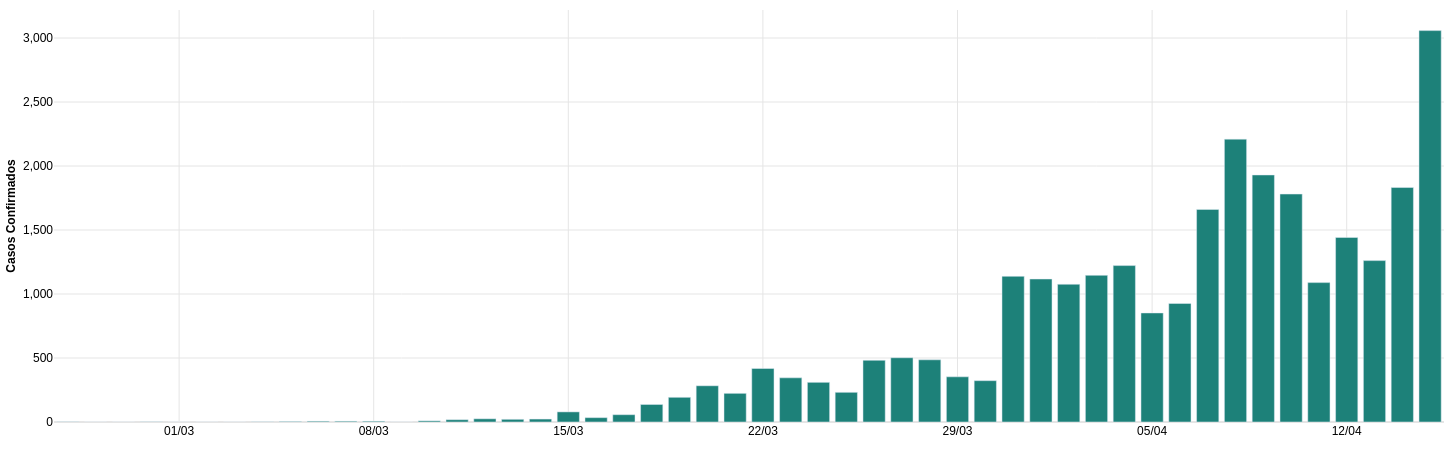

In [21]:
from scripts import vis_graphs

brasil = df_states[df_states['state']=='BRASIL']
brasil['countrycode'] = 'Brasil'
brasil['countryname'] = 'Brasil'

fig = vis_graphs.total_by_country(df = brasil, save=True,geoid='Brasil', var='cases',themes = themes['novo_storage'])

fig

In [24]:
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)
# io.br_daily_genarete_upload(df_states,config['br_daily'],themes)

## MAPS

In [55]:
def _generate_and_upload_br_map(final, estados, map_config):
    #generate map
    cols = ['Município','Estado','Confirmados', 'Óbitos', 'Data do Boletim']
    
    print('Generate and save br map..')
    mymap =  vis_maps.get_map(final,'Confirmados', cols, estados)
    mymap.save(f'{map_config["path_save"]}{map_config["save_name"]}')

    print('Upload br map..')
    io.to_storage(bucket=map_config['bucket'],
              bucket_folder=map_config['bucket_folder'],
              file_name=map_config['save_name'],
              path_to_file=f'{map_config["path_save"]}{map_config["save_name"]}')
    
    os.remove(f'{map_config["path_save"]}{map_config["save_name"]}')

In [56]:
print('Start Br Map')
#minicipales data
municipios = pd.read_csv('../data/br_municipios_ibge.csv', dtype={'geocodigo':str})
df = brio.copy()

#load shape files;
ufs = gpd.read_file('../../mapas_brasil/estados-ibge/BRUFE250GC_SIR.shp')
maps = gpd.read_file('../../mapas_brasil/municipios-ibge/brasil-municipios.shp')

Start Br Map


In [58]:
from scripts import manipulation
from scripts import vis_maps

config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)

#prepare data for map
final, estados = manipulation.manipulate_for_br_maps(brio, municipios, maps, df_states.drop(['regiao'],1), ufs)

# _generate_and_upload_br_map(final, estados, config['br_map'])

## Vale

In [59]:
def _generate_and_upload_vale_map(vale, estados, map_config):
    #generate map
    cols = ['Município','Confirmados','Confirmados Internados','Óbitos','Óbitos Suspeitos','Suspeitos','Suspeitos Internados','Recuperados','Descartados','Data do Boletim']
    
    print('Generate and save vale map..')
    mymap =  vis_maps.get_map_vale(vale,'Confirmados', cols, estados)
    mymap.save(f'{map_config["path_save"]}{map_config["save_name"]}')

    print('Upload vale map..')
    io.to_storage(bucket=map_config['bucket'],
              bucket_folder=map_config['bucket_folder'],
              file_name=map_config['save_name'],
              path_to_file=f'{map_config["path_save"]}{map_config["save_name"]}')
    
    os.remove(f'{map_config["path_save"]}{map_config["save_name"]}')

In [60]:

from scripts.io import read_sheets
from scripts import manipulation
#download and manipulate vale data
df = read_sheets('covid19_vale_do_paraiba_e_litoral_norte')
df = manipulation.manipulate_vale_data(df)

#load shape files
municipios_sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
ufs = gpd.read_file('../../mapas_brasil/estados-ibge/BRUFE250GC_SIR.shp')


In [61]:
## Manipulate data for generate map
config = yaml.load(open('../configs/config.yaml', 'r'), Loader=yaml.FullLoader)

vale, estados = manipulation.manipulate_for_vale_maps(df, municipios_sp, estados)

_generate_and_upload_vale_map(vale, estados, config['vale_map'])


Generate and save vale map..
Upload vale map..
Done!


In [21]:
from scripts import vis_maps

